## Example 5: Grover's Algorithm

### Purpose

This example demonstrates how Grover's Search Algorithm may be used to solve search problems that involve finding the input to a black-box function that produces a particular output. 

### Introduction

There is an important class of problems in computing where you can quickly check a candidate solution, but it is very hard to find the solution other than by trying all the different possibilities or just guessing. For example, you can quickly look up someone's phone number in a  phone book if you know their name, but it is very difficult to find their name if you only know their phone number. Problems of this kind fall in a complexity class known as "NP". In general, for a list of $N$ items it would take order $\mathcal{O}(N)$ steps to go through the possibilities. Grover's algorithm can in principle solve problems of this kind in $\mathcal{O}(\sqrt{N})$ steps on a quantum computer.

We can abstract problems of this kind as a one-way black-box function known as an "oracle". We can ask the oracle whether something is a solution and it will give the reply 'yes' or 'no'.

This notebook starts by looking at how Grover's algorithm works. It then explores a simple example in detail and implements it using TinyQsim. The example involves finding a hidden secret number in the minimum number of guesses. The oracle hides the secret number and can only reply 'yes' or 'no' to the guesses. In a more realistic application, an oracle might check whether something satisfies a constraint, rather than just hiding a pre-existing answer.

Using a simulator, it is only possible to demonstrate the algorithm using a trivial example. For it to be of practical use, a real quantum computer with hundreds or thousands of logical qubits would be necessary.

### Setup

The example will make use of the following Python imports.

In [1]:
from tinyqsim.qcircuit import QCircuit
from tinyqsim.gates import Z, cu
from tinyqsim.quantum import basis_names, n_qubits
from tinyqsim.plotting import plot_histogram
import numpy as np

The following function will be useful to print the maximum probability. If two or more states have this value, only one is printed.

In [2]:
def print_max_probability(qc):
    """Print the state that has the maximum probability."""
    k, v = (max(qc.probability_dict().items(), key=lambda x: x[1]))
    print(f'Max probability = {v:.4f} for state {k}')

It will also be useful to have a function to plot real part of the probability amplitude so that we can see sign flips. Although quantum state vectors are in general complex, in the case of Grover's algorithm they are real, so we don't lose any information by just looking at the real part.

In [3]:
def plot_real_amplitudes(qc):
    """Plot the real part of the probability amplitudes."""
    sv = qc.state_vector
    keys = basis_names(n_qubits(sv))
    plot_histogram(dict(zip(keys, sv)), ylabel='Re(prob.ampl)')

### How the Algorithm Works

Grover's algorithm starts by placing the quantum state into an equal superposition $\ket{s}$ of the $N=2^K$ basis states. The solution we are searching for corresponds to the basis state $\ket{\omega}$. We will assume for simplicity that the problem has a single solution. However, the method can be generalized to cases where there are multiple solutions.

The superposition of the remaining $N-1$ basis states forms the vector $\ket{\omega_\perp}$, which is orthogonal to $\ket{\omega}$. The two vectors $\ket{\omega_\perp}$ and $\ket{\omega}$ span an (unknown) two-dimensional plane in the N-dimensional complex vector space, as shown here:

<img src="assets/grover1.png" style="height:250px">

The initial superposition state is:

$$
\ket{s} = {\small\frac{1}{\sqrt{N}}}\sum_{i=0}^N{\ket{x_i}} = \ket{+\dots +}
$$

This can be written as the sum of two orthogonal vectors:

$$
\ket{s} = \sqrt{\frac{1}{N}}\ \ket{\omega} + \sqrt{\frac{N-1}{N}}\ \ket{\omega_\perp}
$$

Consequently, the angle $\theta$ between $\ket{s}$ and $\ket{\omega_\perp}$ given by:

$$
\theta=\arcsin\left(\frac{1}{\sqrt{N}}\right)
$$

For $N\gg 1$ this can be approximated as:

$$
\theta\approx\frac{1}{\sqrt{N}}
$$

Grover's algorithm starts by initializing the state to the superposition $\ket{s}$ and then performs a sequence of iterations that rotate the state vector until it is close to the solution state $\ket{\omega}$. This results in a high probability of getting the correct solution when the state is measured.

The first two iterations are illustrated by the following diagram:

<img src="assets/grover2.png" style="height:250px">

Each iteration consists of the application of unitary operators $U_\omega$ and $U_s$, where $U_\omega$ is the oracle and $U_s$ is called the Diffusion operator.

- The state is initialized to the equal superposition $\ket{s}=\ket{+\dots +}$
- The operator $U_\omega$ then flips the state about $\ket{\omega_\perp}$ resulting in $U_\omega\ket{s}$
- The operator $U_s$ then flips the state about $\ket{s}$ resulting in $U_sU_\omega\ket{s}$

All the vectors are in the plane spanned by $\ket{\omega}$ and $\ket{s}$. The effect of two flips in a plane, about axes separated by $\theta$, is rotation by $2\theta$ (see diagram).

Successive iterations of $U_sU_\omega$ are applied until the state is as close as possible to the solution state $\ket{\omega}$, which occurs when the total angle is close to $\frac{\pi}{2}$. A measurement of the state then has a high probability of yielding the solution state $\ket{\omega}$.

So the overall algorithm is as follows:

- Calculate the number of iterations $\nu$ that are needed.
- Initialize the state to the equal superposition $\ket{s}$
- Repeat $\nu$ times:
  - Apply the oracle $U_\omega$
  - Apply the diffusion operator $U_s$
- Measure the state, yielding the result $\omega$ with high probability.

### Knowing when to Stop

The total angle $\phi$ starts at $\theta$ and increases by $2\theta$ with each iteration. After $\nu$ iterations, the total angle $\phi$ is:

$$
\phi=(2\nu+1)\ \theta\approx\frac{1}{\sqrt{N}}(2\nu+1)
$$

We want this to be as close to $\frac{\pi}{2}$ as possible. Consequently, the required number of iterations, which must be an integer, is:

$$
\nu = \left\lfloor\frac{\pi}{4}\sqrt{N}\right\rfloor
$$

This explains why the algorithmic complexity, in terms of the number of iterations, is $\mathcal{O}(\sqrt{N})$.

The following function can be used to calculate $\nu$:

In [4]:
def required_iterations(k: int):
    """Return the optimum number of Grover iterations.
    :param k: number of bits
    """
    return int(np.sqrt(2**k) * np.pi / 4)

The probability $P(\nu, K)$ of measuring the correct result after $\nu$ iterations is:

$$
\begin{align*}
P(\nu, K) &= \sin^2(\phi)\\
&\approx\sin^2\left[(2\nu + 1)\frac{1}{\sqrt{2^K}}\right]
\end{align*}
$$

When $N$ is large, which will normally be the case for problems where the algorithm is needed, the probability of getting the correct result is very close to one.

In [5]:
def prob(nu, K):
    """Return the probability of success after nu iterations."""
    return np.sin((2 * nu + 1) /np.sqrt(2**K)) ** 2

### Reflections

An operator $U_x$ which reflects about the hyperplane orthogonal to $\ket{x}$ can be defined as:

$$
U_x = \mathbb{I} - 2\ket{x}\bra{x}
$$

To see why this is the case, we can apply it to a vector $\ket{\psi}$:

$$
\begin{align*}
U\ket{\psi} &= (\mathbb{I}-2\ket{x}\bra{x})\ \ket{\psi}\\[0.4em]
&= \ket{\psi}-2\ket{x}\braket{x|\psi}\\[0.4em]
&= \begin{cases}
      -\ket{\psi}, & \text{if $\psi=x$}\\
      +\ket{\psi}, & \text{if $\psi \ne x$}
\end{cases}
\end{align*}
$$

It flips the component of the vector $\ket{\psi}$ that is along $\ket{x}$, while leaving the other components which are orthogonal to $\ket{x}$ unchanged. This is equivalent to reflecting $\ket{\psi}$ about the hyperplane orthogonal to $\ket{x}$.

### MCZ Gate

In order to perform the flip operations, we will make use of a Multi-Controlled-Z (MCZ) gate. When an MCZ appears in an algebraic expression as an operator, it will be denoted by $M_{cz}$ so that it isn't confused with the composition of three separate operators.

$M_{cz}$ is equivalent to the $U_x$ operator described above, for the specific case of $\ket{x}=\ket{1\dots 1}$.

$$
M_{cz}=\mathbb{I}-2\ket{1\dots 1}\bra{1\dots 1}
$$

In other words, it flips the sign of the $\ket{1\dots 1}$ state and leaves all the others unchanged.

$$
M_{cz}\ket{x} = \begin{cases}
      -\ket{x}, & \text{if $\ket{x}=\ket{1\dots 1}$}\\
      +\ket{x}, & \text{if $\ket{x}\ne\ket{1\dots 1}$}
\end{cases}
$$

It is easy to make it work for vectors other than $\ket{1\dots 1}$, by applying a suitable transformation. Consequently, we can use it to implement both the oracle and the diffusion operator.

The following is a simple implementation of a K-qubit MCZ gate in TinyQsim as a matrix. There are other ways to implement an MCZ that scale better for more qubits, but this will suffice as the purpose of this notebook is just to demonstrate the principle of Grover's algorithm. 

In [6]:
def mcz(qc, k):
    """Multi-controlled Z gate applied to qubits 0 to k-1."""
    qc.u(cu(Z, k-1), 'MCZ', *range(k))

---

### The Example Problem

For our example, the oracle will hide a secret K-bit binary number. Our goal is to find the secret number by asking the oracle whether specific "guesses" are correct, without going through the $N=2^K$ possibilities one at a time. On a classical computer it would take $\frac{N}{2}$ attempts on average and $N$ in the worst case. With a quantum computer we can solve it in order $\mathcal{O}(\sqrt{N})$ attempts with very high probability. The advantage of the quantum algorithm gets progressively better as the size of the search space increases.

The $2^K$ possible values are represented as the basis states of a K-qubit quantum state. If we query the oracle with the correct solution state, it will indicate its "yes" answer by flipping the sign of the state, otherwise it will leave the sign unchanged.

### The Oracle

The oracle $U_\omega$ reflects across the hyperplane orthogonal to $\ket{\omega}$:

$$
U_\omega = \mathbb{I} - 2\ket{\omega}\bra{\omega}
$$

It flips the component of the state vector along $\ket{\omega}$ while leaving the other components orthogonal to $\ket{\omega}$ unchanged.

An MCZ gate on its own could serve as the oracle for an all-ones key $11\dots 1$. For an arbitrary key, we just need to invert the qubits that have a $0$ bit in the key. The oracle encoding a specific key can be created using the following function:

In [7]:
def flip_sign(qc, key:[int]):
    """Flip sign of the basis state defined by a key.
    :param qc: QCircuit instance
    :param secret: Binary number as list of 0s and 1s
    """
    k = len(key)
    bits = [i for i, s in enumerate(key) if s==0]
    qc.x(bits)
    mcz(qc,k)
    qc.x(bits)

To demonstrate this for a secret key of 0101:

In [8]:
def oracle(qc):
    flip_sign(qc, [0,1,0,1])  # Secret number 0101 in binary  

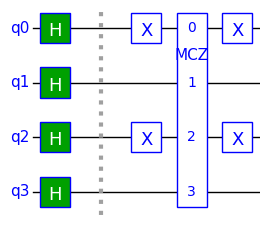

In [9]:
K = 4
qubits = range(K)
qc = QCircuit(K)
qc.h(qubits)  # Initial superposition
qc.barrier()
oracle(qc)
qc.draw()

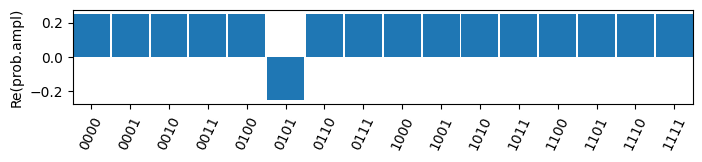

In [10]:
plot_real_amplitudes(qc)

The input is a superposition of all basis states, but only the basis state $\ket{0101}$ has  its sign flipped.

### The Diffusion Operator

The diffusion operator $U_s$ flips the state vector about the $\ket{s}$ vector which is the equal superposition state $\ket{+\dots +}$.

$$
U_s = 2\ket{s}\bra{s} - \mathbb{I}
$$

An MCZ gate flips the sign of the $\ket{1\dots 1}$ component:

$$
M_{cz}=\mathbb{I}-2\ket{1\dots 1}\bra{1\dots 1}
$$

In order to make it flip the state about the $\ket{s}$ vector, we can make the following transformation:

$$
U_s= - (H^{\otimes K}X^{\otimes K}\ M_{cz}\ X^{\otimes K}H^{\otimes K})
$$

The $X$ gates make $M_{cz}$ flip $\ket{0\dots 0}$ instead of $\ket{1\dots 1}$. Then the $H$ gates make it flip $\ket{+\dots +}$ instead of $\ket{1\dots 1}$.

The negative sign results from the reversed order of terms. It can be ignored because it represents a global phase of $\pi$, which has no measurable effect.

In [11]:
def diffusion(qc, k):
    """Grover diffusion operator."""
    qubits = range(k)
    qc.h(qubits)
    qc.x(qubits)
    mcz(qc,k)
    qc.x(qubits)
    qc.h(qubits)

### The First Iteration

We will put the pieces of the algorithm together and run the first iteration:

#### (a) Define the Oracle

In [12]:
def oracle(qc):
    flip_sign(qc, [0,1,0,1])  # Secret number 0101 in binary  

#### (b) Create the Superposition State

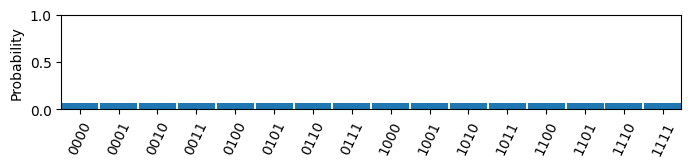

In [13]:
qc = QCircuit(K)
qc.h(qubits)

qc.plot_probabilities(ylim=[0,1])
qc.barrier()

#### (c) Apply the Oracle

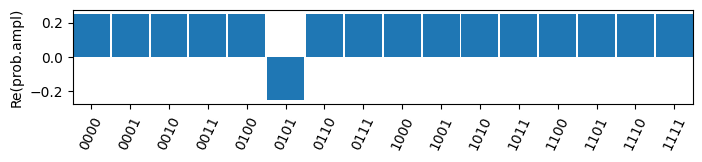

In [14]:
oracle(qc)

plot_real_amplitudes(qc)
qc.barrier()

#### (d) Apply the Diffusion Function

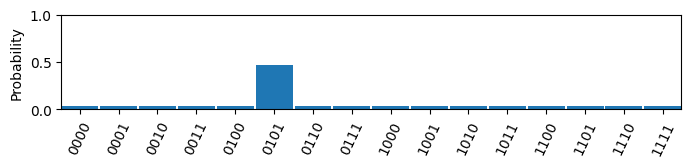

Max probability = 0.4727 for state 0101


In [15]:
diffusion(qc, K)

qc.plot_probabilities(ylim=[0,1])
print_max_probability(qc)
qc.barrier()

The first iteration has amplified the probability of the solution state significantly. If we made a measurement now, there would be 47% probability of getting the correct solution.

It was shown earlier that the optimum number of iterations $\nu$ is given by:

$$
\nu = \left\lfloor\frac{\pi}{4}\sqrt{N}\right\rfloor
$$

For this example, with $N=16$, the optimum number is $\nu=3$, so we need to do two more iterations.

In [16]:
nu = required_iterations(K)
print(f'nu = {nu}')

nu = 3


### The Circuit So Far

The following diagram shows the circuit so far. It is divided into three sections for clarity using the vertical dotted-line barriers:

- Hadamard gates to create superposition
- The oracle
- The diffusion operator

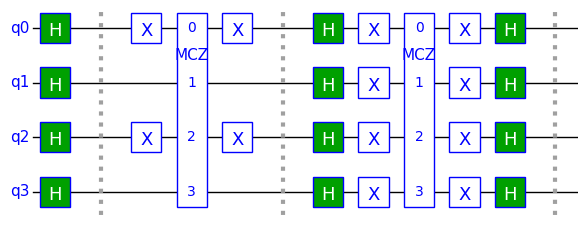

In [17]:
qc.draw()

### Iteration 2

Each iteration consists of two steps: applying the oracle and applying the diffusion operator:

In [18]:
oracle(qc)
diffusion(qc, K)

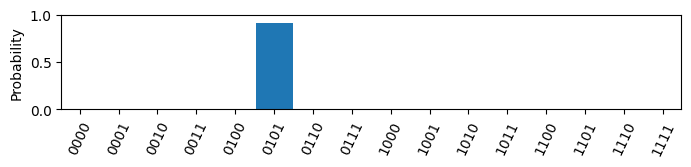

Max probability = 0.9084 for state 0101


In [19]:
qc.plot_probabilities(ylim=[0,1])
print_max_probability(qc)

The probability of a measurement giving the correct result has increased to about 91%.

### Iteration 3

In [20]:
oracle(qc)
diffusion(qc, K)

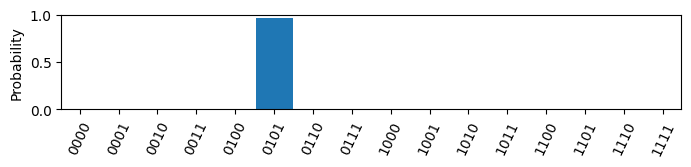

Max probability = 0.9613 for state 0101


In [21]:
qc.plot_probabilities(ylim=[0,1])
print_max_probability(qc)

We have completed the three iterations needed and the probability of getting the correct result is now 96%, so it is time to measure.

### Measurement

In [22]:
print(f'Result = {qc.measure()}')

Result = [0 1 0 1]


This result should be the same as the secret number used by the oracle.

The probability of getting an incorrect result is $1 - 0.96 = 0.04$. If this happens, we just need to run the process again. The oracle function is by its nature one that makes it easy to check the result. The probability of both measurements being wrong is $0.04^2 = 0.0016$.

Of course, on a real quantum computer, we don't have access to the probabilities, but we can estimate them as follows:

In [23]:
print(f'Calculated probability = {prob(nu, K):.3f}')

Calculated probability = 0.968


---

### Putting it all Together

We can put the steps of the algorithm together as a function 'grover_solver' that finds the solution for a given oracle:

In [24]:
def grover_solver(k, oracle):
    nu = required_iterations(k)
    print(f'# iterations = {nu}\n')

    qc = QCircuit(k)
    qc.h(range(k))
    for i in range(nu):
        oracle(qc)
        diffusion(qc, k)
    return qc.measure()

The following example shows the solver being used to find an 8-bit secret key.

In [25]:
SECRET = [0,1,1,0,1,0,0,0]
k = len(SECRET)

def oracle(qc):
    return flip_sign(qc, SECRET)

result = grover_solver(k, oracle) 

print(f'Result = {result}')
print(f'Secret = {np.array(SECRET)}')

# iterations = 12

Result = [0 1 1 0 1 0 0 0]
Secret = [0 1 1 0 1 0 0 0]


The result should agree with the secret.

This demonstration can only handle a few qubits because it is not running on a quantum computer. In addition, the simple implementation of the MCZ gate used is very inefficient as it involves creating a $2^K\times 2^K$ matrix.

### Conclusions

This example has demonstrated Grover's Algorithm applied to the simple example of finding a hidden key. In a more realistic application, an oracle might check whether something satisfies a constraint, rather than just hiding a pre-existing answer. It may also be used to solve problems that have more than one solution.

This example used a large matrix to provide a simple implementation of the MCZ gate for simulation. This scales very badly with the number of qubits. There are other ways to implement the operation, such as using ancilla qubits with many smaller gates.

To be of practical use, the algorithm would require a real quantum computer with hundreds of logical (error-free) qubits. On today's Noisy Intermediate-Scale Quantum (NISQ) devices, it doesn't yet give any advantage.

The method provides a quadratic speedup compare with a classical computation, requiring $\mathcal{O}(\sqrt{N})$ steps instead of $\mathcal{O}(N)$. Applied to reversing a hash function such as SHA-256, it would require on the order of $2^{128}$ steps instead of $2^{256}$. That is around $10^{40}$, which is still unfeasible even with a quantum computer.

However, Grover's algorithm illustrates a more general approach to quantum algorithm design that involves starting with a superposition of all possibilities and then iteratively using amplitude amplification to increase the probability of the solution state.